# SciPyCubicSpline vs PyCubicSpline

In [46]:
import numpy as np
import pandas as pd

from numpy import ndarray
from numpy.typing import ArrayLike
from bisect import bisect
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Import Waypoints

In [47]:
dir_path = 'waypoints.csv'
df = pd.read_csv(dir_path)
x = df['x'].values
y = df['y'].values

## SciPyCubicSpline

In [48]:
def initialise_cubic_spline(x: ArrayLike, y: ArrayLike, ds: float, bc_type: str) -> tuple[CubicSpline, ndarray]:

    distance = np.concatenate((np.zeros(1), np.cumsum(np.hypot(np.ediff1d(x), np.ediff1d(y)))))
    points = np.array([x, y]).T
    s = np.arange(0, distance[-1], ds)
    cs = CubicSpline(distance, points, bc_type=bc_type, axis=0, extrapolate=False)
    return cs, s

def scipycubicspline(x: ArrayLike, y: ArrayLike, ds: float=0.05, bc_type: str='natural') -> tuple[ndarray, ndarray, ndarray, ndarray]:
    
    cs, s = initialise_cubic_spline(x, y, ds, bc_type)

    dx, dy = cs.derivative(1)(s).T
    yaw = np.arctan2(dy, dx)

    ddx, ddy = cs.derivative(2)(s).T
    curvature = (ddy*dx - ddx*dy) / ((dx*dx + dy*dy)**1.5)

    cx, cy = cs(s).T
    return cx, cy, yaw, curvature

## PyCubicSpline

In [49]:
class Spline:

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

        self.a = y
        self.b = []
        self.d = []

        dim_size = len(x)
        h = np.diff(x)

        A = self.matrixA(h, dim_size)
        B = self.matrixB(h, dim_size)
        self.c = np.linalg.solve(A, B)

        for i in range(dim_size - 1):
            self.b.append((self.a[i + 1] - self.a[i])/h[i] - h[i]*(self.c[i + 1] + 2.0*self.c[i]) / 3.0)
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))

    def matrixA(self, h, size):
        
        A = np.zeros((size, size))
        A[0, 0] = 1.0

        for i in range(size - 1):
            if i != (size - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[size - 1, size - 2] = 0.0
        A[size - 1, size - 1] = 1.0

        return A

    def matrixB(self, h, size):
        
        B = np.zeros(size)

        for i in range(size - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
            
        return B

    def solve_function(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = self.a[i] + self.b[i]*delta_x + self.c[i]*delta_x*delta_x + self.d[i]*delta_x*delta_x*delta_x

            return result

    def solve_1st_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = self.b[i] + 2.0*self.c[i]*delta_x + 3.0*self.d[i]*delta_x*delta_x

            return result

    def solve_2nd_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = 2.0*self.c[i] + 6.0*self.d[i] * delta_x

            return result

    def search_index(self, x):

        i = bisect(self.x, x) - 1

        return i

class Spline2D:

    def __init__(self, x, y):

        self.ds = None

        self.s = self.calculate_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def calculate_s(self, x, y):
        
        delta_x = np.diff(x)
        delta_y = np.diff(y)
        self.ds = np.hypot(delta_x, delta_y)

        s = [0]
        s.extend(np.cumsum(self.ds))

        return s

    def calculate_position(self, s):
        
        x = self.sx.solve_function(s)
        y = self.sy.solve_function(s)

        return x, y

    def calculate_yaw(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        yaw = np.arctan2(dy, dx)

        return yaw

    def calculate_curvature(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        ddx = self.sx.solve_2nd_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        ddy = self.sy.solve_2nd_derivative(s)

        k = (ddy*dx - ddx*dy) / ((dx*dx + dy*dy)**1.5)

        return k

def pycubicspline(x, y, ds=0.05):

    sp2d = Spline2D(x, y)
    s = np.arange(0, sp2d.s[-1], ds)

    px = []
    py = []
    pyaw = []
    pk = []

    for i in s:
        ix, iy = sp2d.calculate_position(i)
        px.append(ix)
        py.append(iy)
        pyaw.append(sp2d.calculate_yaw(i))
        pk.append(sp2d.calculate_curvature(i))

    return px, py, pyaw, pk

## Tests

- SciPyCubicSpline should be faster than PyCubicSpline
- SciPyCubicSpline should be more or similar in accuracy than PyCubicSpline

### TimeIt

In [50]:
%%capture

ds = 0.1
scipycubicspline_t  = %timeit -o scipycubicspline(x, y, ds)
pycubic_spline_t = %timeit -o pycubicspline(x, y, ds)

821 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
69.9 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
print(f"SciPyCubicSpline test: \n{scipycubicspline_t}")
print(f"PyCubicSpline test: \n{pycubic_spline_t}")

Scipy test: 
821 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Python test: 
69.9 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Profiling

In [52]:
%lprun -f generate_cubic_spline_scipy -f initialise_cubic_spline scipycubicspline(x, y, ds)

Timer unit: 1e-06 s

Total time: 0.000939 s
File: /tmp/ipykernel_4439/1554491529.py
Function: initialise_cubic_spline at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def initialise_cubic_spline(x: ArrayLike, y: ArrayLike, ds: ArrayLike, bc_type: str) -> tuple[CubicSpline, ndarray]:
     2                                           
     3         1         63.0     63.0      6.7      distance = np.concatenate((np.zeros(1), np.cumsum(np.hypot(np.ediff1d(x), np.ediff1d(y)))))
     4         1         85.0     85.0      9.1      points = np.array([x, y]).T
     5         1        123.0    123.0     13.1      s = np.arange(0, distance[-1], ds)
     6         1        667.0    667.0     71.0      cs = CubicSpline(distance, points, bc_type=bc_type, axis=0, extrapolate=False)
     7         1          1.0      1.0      0.1      return cs, s

Total time: 0.001879 s
File: /tmp/ipykernel_4439/1554491529.py
Function: genera

In [53]:
%lprun -f generate_cubic_path pycubicspline(x, y, ds)

Timer unit: 1e-06 s

Total time: 0.180827 s
File: /tmp/ipykernel_4439/4278668345.py
Function: generate_cubic_path at line 148

Line #      Hits         Time  Per Hit   % Time  Line Contents
   148                                           def generate_cubic_path(x, y, ds=0.05):
   149                                           
   150         1          2.0      2.0      0.0      if len(x) != len(y):
   151                                                   print("Length of x and y must be equal")
   152                                                   exit()
   153                                           
   154         1       1522.0   1522.0      0.8      sp2d = Spline2D(x, y)
   155         1        527.0    527.0      0.3      s = np.arange(0, sp2d.s[-1], ds)
   156                                           
   157         1          1.0      1.0      0.0      px = []
   158         1          0.0      0.0      0.0      py = []
   159         1          0.0      0.0      0.0     

### Accuracy

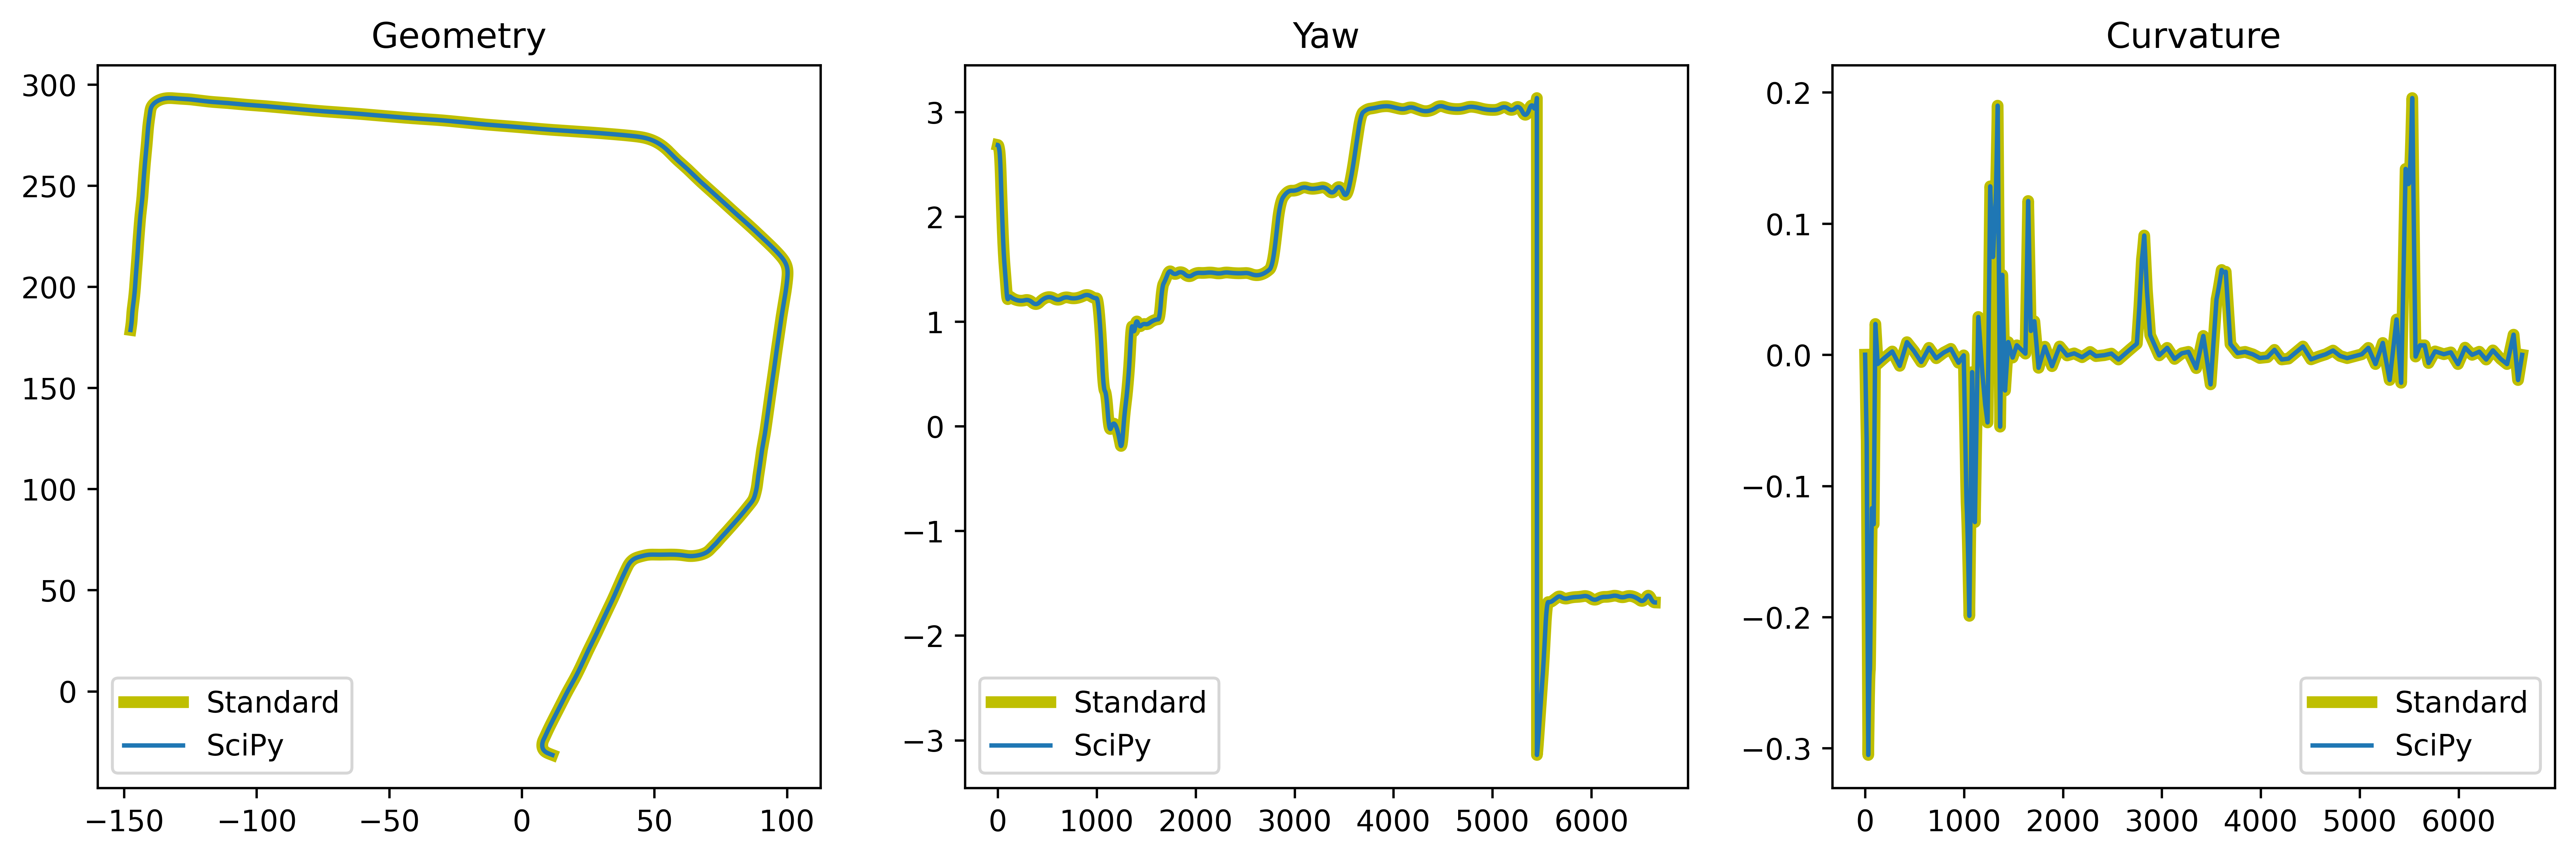

In [54]:
%matplotlib inline

sx, sy, syaw, sk = scipycubicspline(x, y, ds)
px, py, pyaw, pk = pycubicspline(x, y, ds)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

ax[0].set_box_aspect(1)
ax[0].set_title('Geometry')
ax[0].plot(px, py, color='y', linewidth=4, label='Standard')
ax[0].plot(sx, sy, label='SciPy')
ax[0].legend()

ax[1].set_box_aspect(1)
ax[1].set_title('Yaw')
ax[1].plot(pyaw, color='y', linewidth=4, label='Standard')
ax[1].plot(syaw, label='SciPy')
ax[1].legend()

ax[2].set_box_aspect(1)
ax[2].set_title('Curvature')
ax[2].plot(pk, color='y', linewidth=4, label='Standard')
ax[2].plot(sk, label='SciPy')
ax[2].legend()

plt.show()

### Similarity

In [55]:
calculate_1d_cosine_similarity = lambda a, b : np.inner(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))

k_sim = calculate_1d_cosine_similarity(pk, sk) * 100
yaw_sim = calculate_1d_cosine_similarity(pyaw, syaw) * 100
print(f"Curvature similarity: {np.round(k_sim, 7)}%")
print(f"Yaw similarity: {np.round(yaw_sim, 7)}%")

Curvature similarity: 100.0%
Yaw similarity: 100.0%
